# Nomad2018 Predicting Transparent Conductors

This notebook was created in order to provide an account of the performance in the competition. The following **sells may not be executable locally** bacause of lack of data files and customly implemented libraries. 

In [16]:
import numpy as np 
import pandas as pd 
from sklearn import manifold
import warnings
warnings.filterwarnings('ignore')
%pylab inline

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

Populating the interactive namespace from numpy and matplotlib


## Data observation
Let's see how initial data looks like:

In [17]:
print(train.shape, test.shape)
train.head()

(2400, 14) (600, 12)


,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


There are 2 categorical features, the rest are numerical. They mostly describe the charactristics of a unit cell of the specified compound. 

For each object the separate **geometry.xyz** file is provided. It contains coordinates of all atoms in unit cell.

In [18]:
xyz = pd.read_table('data/train/1/geometry.xyz')
xyz.head(7)

,#=======================================================
0,#Created using the Atomic Simulation Environme...
1,#=============================================...
2,lattice_vector 9.9520877199999997 -0.047248240...
3,lattice_vector 0.0403159900000000 8.5511748500...
4,lattice_vector 0.0316403800000000 0.0096659200...
5,atom 1.6088879366700000 7.2764162181499996 6.3...
6,atom 6.5849317966699994 7.2527920981499996 6.3...


Table above shows a piece of **.xyz** file. Lattice vectors information is redundant, because it is already placed to the initial table, but coordinates info is not (rows 5 and below). Each row corresponds to a particular atom position so the table is Nx3, where N is the **number_of_total_atoms** feature from the first table. The target features are just two numbers, representing energetic components of the corresponding materials (mode detailed information is accessible on the competition's page on Kaggle.com

## Data visualization
Some problems can be easily solved when inner data relationships get clearly understood. Visualization is obviously a good way to understand data. Here we used t-SNA method to visualize possible inner structure of training set in order to predict formation energy.

In [19]:
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
data_2d_tsne = tsne.fit_transform(train)

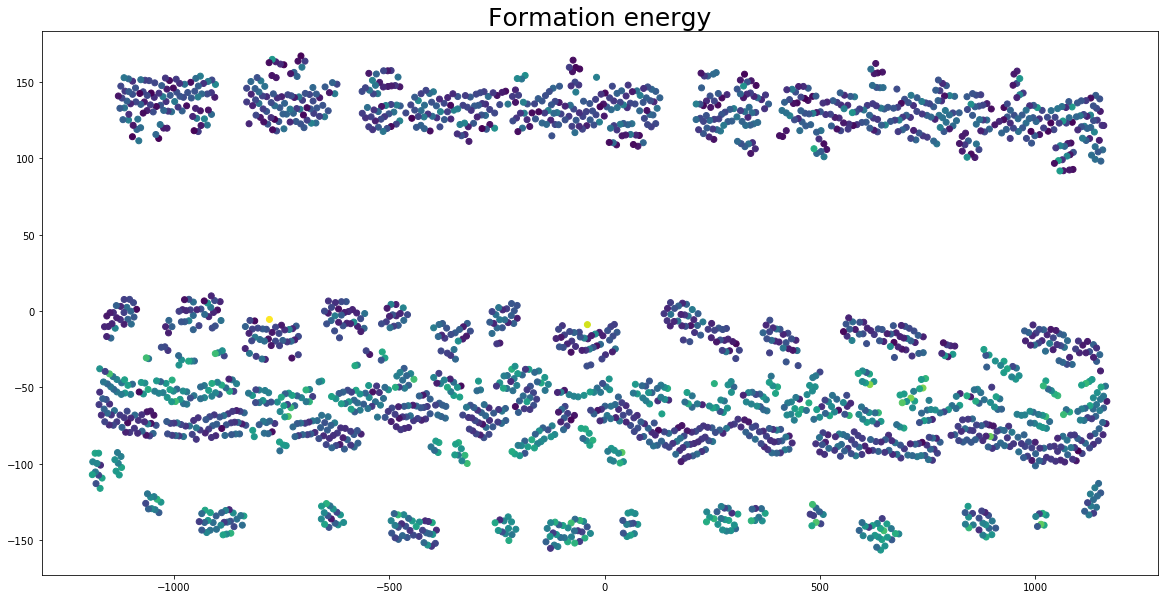

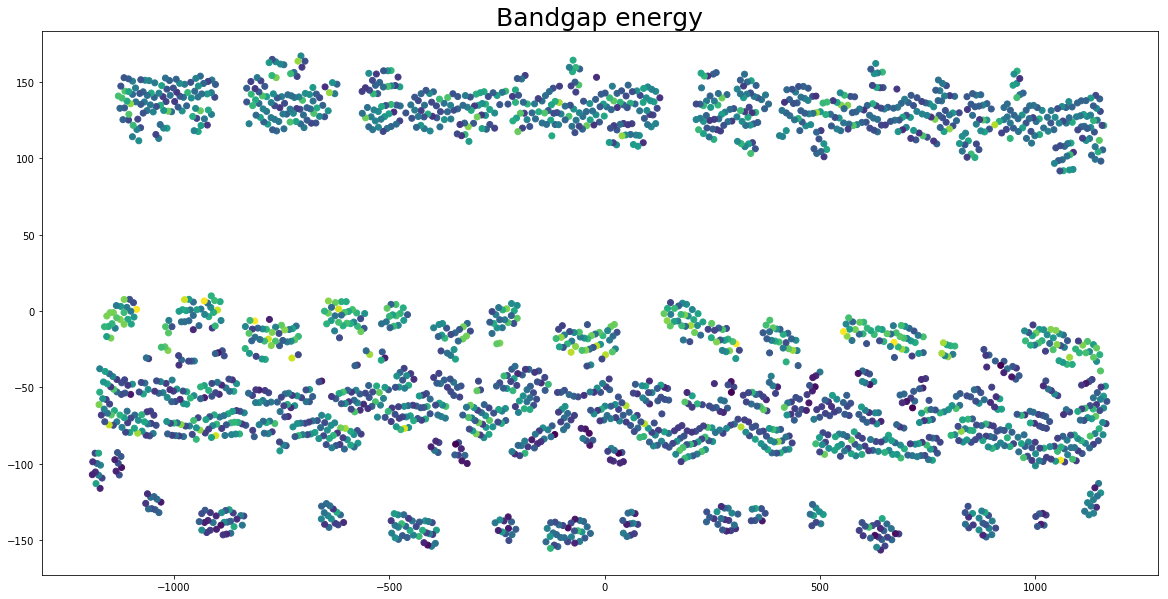

In [20]:
pylab.figure(figsize = (20, 10))
pylab.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c = train['formation_energy_ev_natom']), plt.title('Formation energy', fontsize=25)
pylab.figure(figsize = (20, 10))
pylab.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c = train['bandgap_energy_ev']), plt.title('Bandgap energy', fontsize=25)
plt.show()

Intensity of blue corresponds to formation enerhy value (higher is darker) and bandgap energy value (higher is darker) respectively. Here we can see that there is no clear division into clusters so it might be hard to find some patterns using standart clustering techniques.

## Cross-validation
The main idea of our cross-validation was to devide train set into 6 folds (to remain train-test proportions like ones in test set) and learn on all data, including noises. The problem with noise was solved the following way: trained models were validated only on "normal" objects. As "normal" were considered objects which formation and bandgap energies were predicted with error less then prediction error for other 95% of objects. 

In [21]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_predict


estimator = lgb.LGBMRegressor(random_state=0) 
y_pred = cross_val_predict(estimator = estimator,
                           X = train.drop(['id', 'formation_energy_ev_natom', 'bandgap_energy_ev'], axis=1),
                           y = train['formation_energy_ev_natom'],
                           cv = 6) 
y_pred

array([0.06699088, 0.19469313, 0.18241867, ..., 0.10414278, 0.25904185,
       0.11438828])

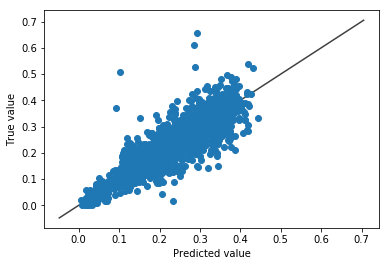

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(y=train['formation_energy_ev_natom'], x=y_pred)
ax.set_xlabel('Predicted value')
ax.set_ylabel('True value')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

Here we may clearly see that majority of predictions are close to true values. There is some noise though. If "bad" objects were left it would lead to displaced mathmatical expectation. We may assume that errors distribution is close to normal then it becomes easy to find 95% confidence interval the following way:

In [23]:
diff = train['formation_energy_ev_natom'] - y_pred
mean = diff.mean()                                                            # sample mean
S = S = np.std(diff, ddof=1)                                                  # sample standart deviation

# plane two sigma
Cl = mean - 2 * S
Ct = mean + 2 * S
print('{} <= X <= {}'.format(Cl, Ct))

-0.08313460428605982 <= X <= 0.08387888905820404


Those objects with error not included in the interval will not participate in model validation.

(2252,) (148,)


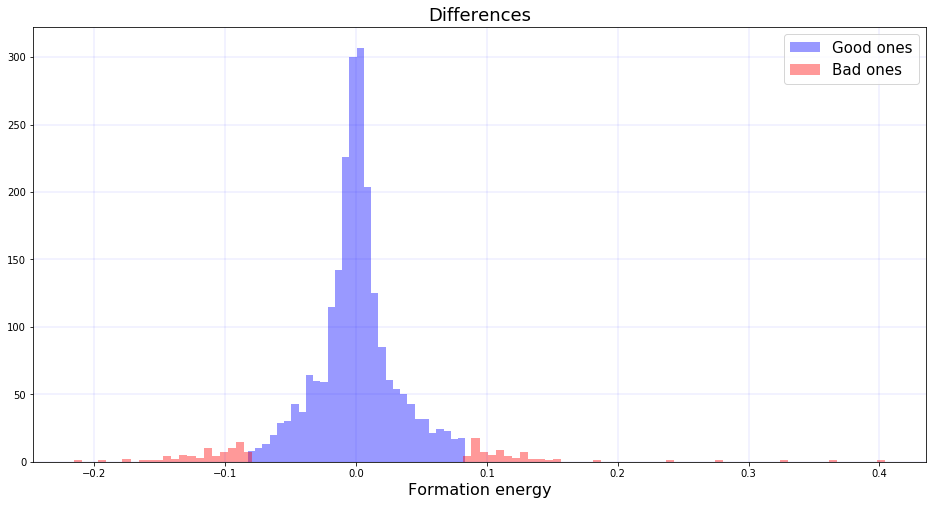

In [24]:
diffs_95 = diff[(diff > Cl) & (diff < Ct)]
diffs_noise = diff[(diff <= Cl) | (diff >= Ct)]
print(diffs_95.shape, diffs_noise.shape)

plt.figure(figsize=(16,8))
sns.distplot(diffs_95, bins=30, color='b', kde=False, label='Good ones')
sns.distplot(diffs_noise, bins=100, color='r', kde=False, label='Bad ones')
plt.legend(fontsize=15)
plt.title('Differences', fontsize=18)
plt.xlabel('Formation energy', fontsize=16)
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.show()

## Feature extraction
The most obvious feature, which could have been extracted from the table's contents was lattice angle destortions. They, let's say, characterize the degree of irregularity, which makes a huge impact on both target energies.

In [27]:
distortions = pd.read_csv('data/add/train_distortions.csv')
distortions.head(3)

,id,lattice_distortion_alpha_degree,lattice_distortion_beta_degree,lattice_distortion_gamma_degree
0,1,0.0026,0.0023,0.0017
1,2,0.0186,-0.0020,0.0025
2,3,0.9688,1.1228,0.5185


Huge amount of work was made to extract useful features from atomic coordinates:

* Volume and density of unit cells were calculated based on information about cell and atomic sizes.

* Coordination numbers and average pairwise distances between each type atoms were calculated using ASE library.

* PCA was heavily used on both initial and reduced coordinates (all coordinates were mapped on a segment [0,1]). Two main components for each atom type from both initial and reduced coordinated were proved to give the hightest boostup for the model. They were extracted seperately and then added to a resulting dataset.

In [28]:
dens_vol = pd.read_csv('data/add/train_volume.csv')
local_str = pd.read_csv('data/add/train_local_structure.csv')
reduced_pca = pd.read_csv('data/add/train_new_pca.csv')
tr_prep = pd.read_csv('data/train_prepared.csv')

dens_vol['Coord_Num_between_Al_Al'] = local_str['CN_Al_Al']
dens_vol['Avg_dist_between_Al_Al'] = local_str['RR_Al_Al']
dens_vol['Ga_comp_on_reduced_coords'] = reduced_pca['Ga_new_0']
dens_vol['Ga_comp_on_init_coords'] = tr_prep['Ga_0']

dens_vol.head(3)

,id,volume,density,Coord_Num_between_Al_Al,Avg_dist_between_Al_Al,Ga_comp_on_reduced_coords,Ga_comp_on_init_coords
0,1,781.052081,0.102426,3.374255,3.250,-0.633129,-6.919791
1,2,782.500110,0.102236,1.190561,3.075,-0.410438,-10.811701
2,3,391.227531,0.102242,2.747714,3.325,-0.322613,-1.524974


Examples of extracted reatures are provided above.

#### Clustering for feature generation
The turget features destrubutions:

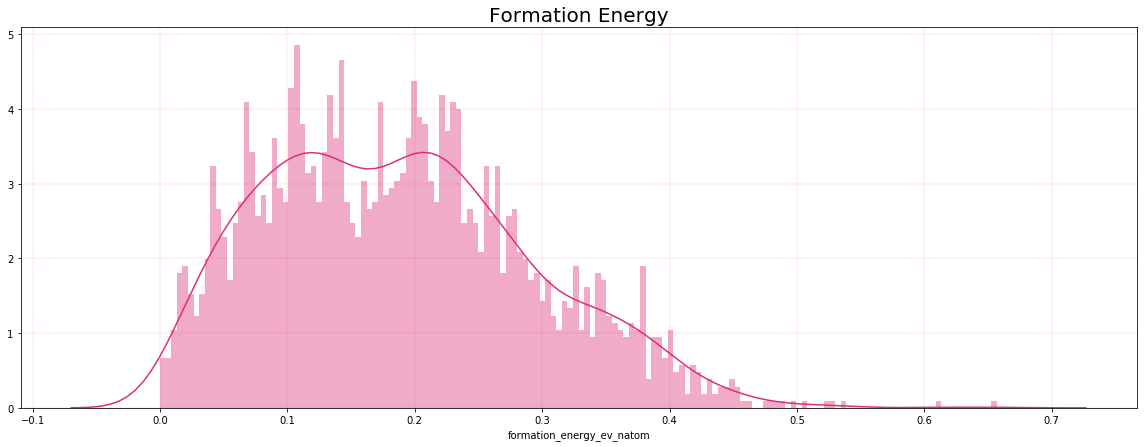

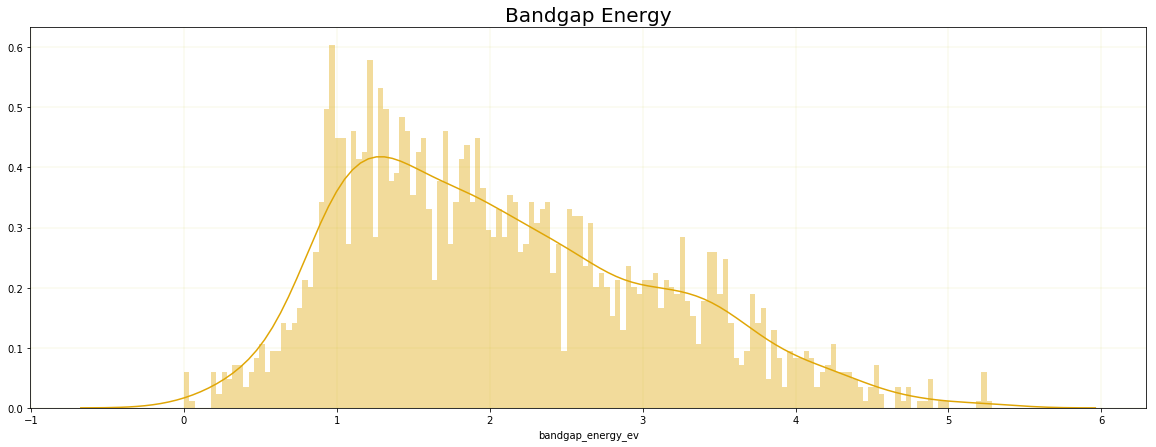

In [29]:
plt.figure(figsize=(20,7))
sns.distplot(train['formation_energy_ev_natom'], bins=150, color='#db2e79')
plt.title('Formation Energy', fontsize=20)
plt.grid(color='r', linestyle='-', linewidth=0.1)

plt.figure(figsize=(20,7))
sns.distplot(train['bandgap_energy_ev'], bins=150, color='#e0a606')
plt.title('Bandgap Energy', fontsize=20)
plt.grid(color='y', linestyle='-', linewidth=0.1)

It is easy to mention that target features have polymodal destributions.

Several clustering techniques were applied on raw data. One idea was to divide trimodal destribution on three clusters with either Mean shift, K-means, Spectral clustering or DBSCAN. Let's see how Mean shift performed on this task:

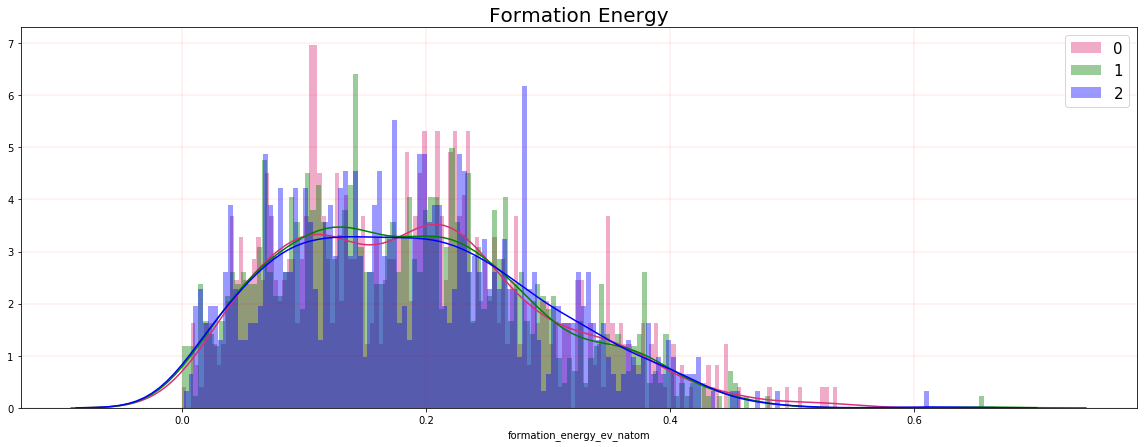

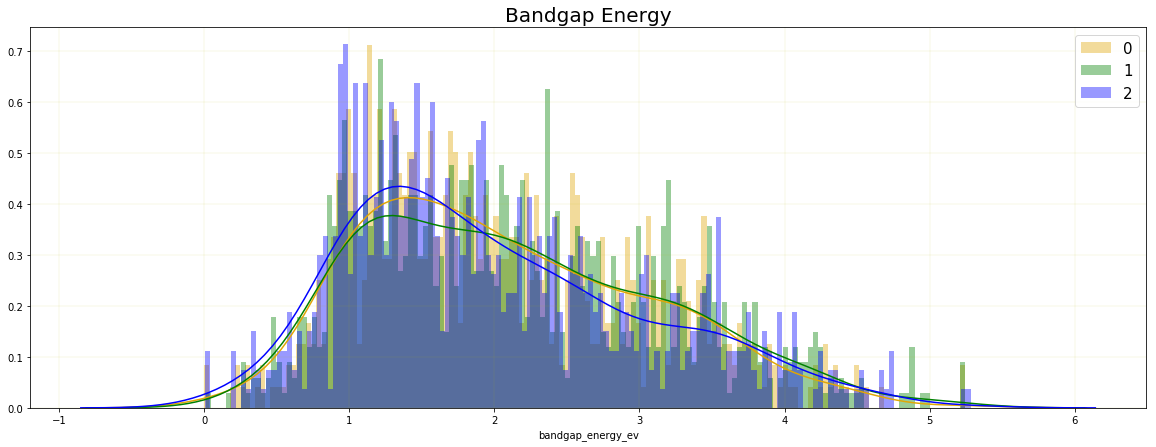

In [30]:
from sklearn.cluster import MeanShift
from lib.clustering import cluster, visualize_clusters

ms = MeanShift(n_jobs=-1)
ltr, ltst = cluster(ms, train, test)
visualize_clusters(train, ltr)

The results of other algorithms were pretty similar to this one: they neither gave the way to devide the data into 3 different clusters for the purpose of training separate regressors on them nor gave statisticaly significant model improvement as features. 

Interestingly enough to mention that during validation of work of different algorithms with various number of classes it turned out that clustering with **K-means** on **100** regions and adding result as a feature significantly increased model quality.

The other suggested approach was to use only target features for clustering. Though it led to desirable classes division, it was not satisfactory enough so some noize was added by performing clustering not only on target features, but also __lattice_angle_gamma_degree__ was added (as the most highly correlated with both targets feature). The result of clustering is below:

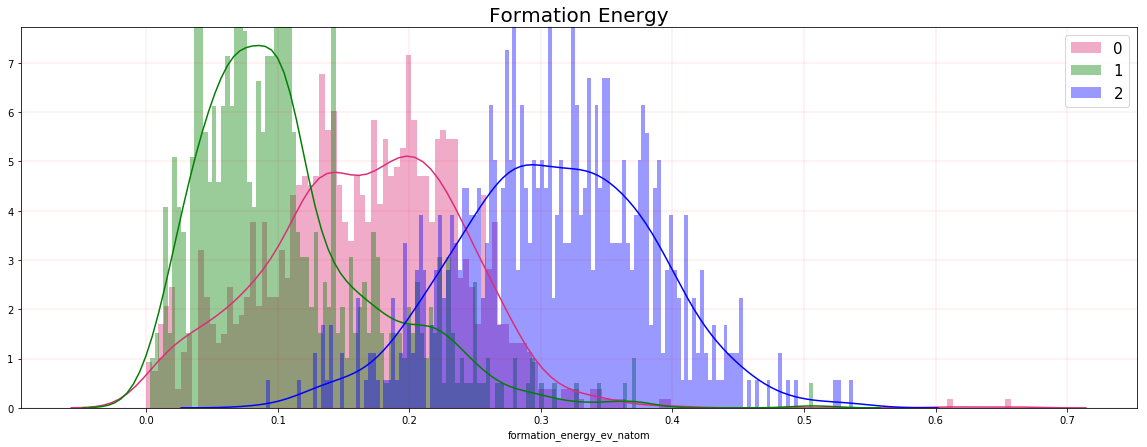

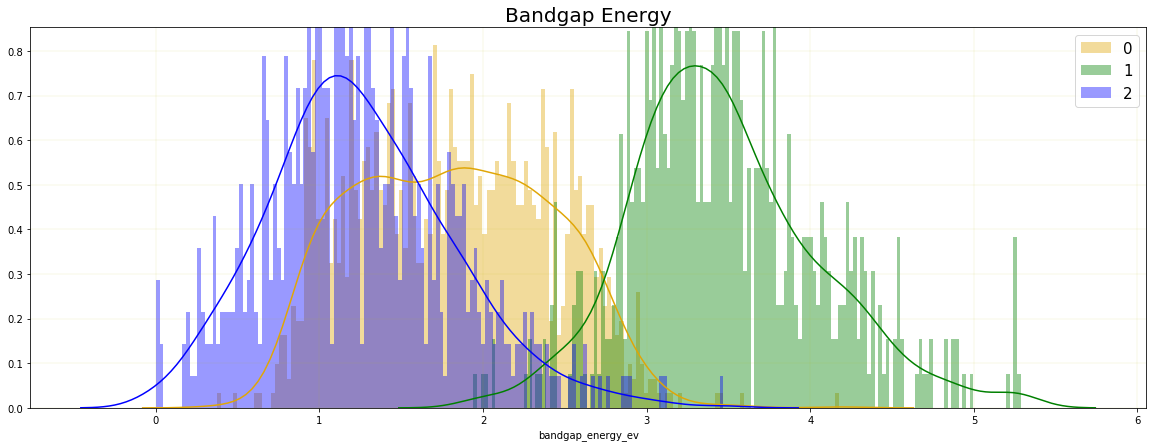

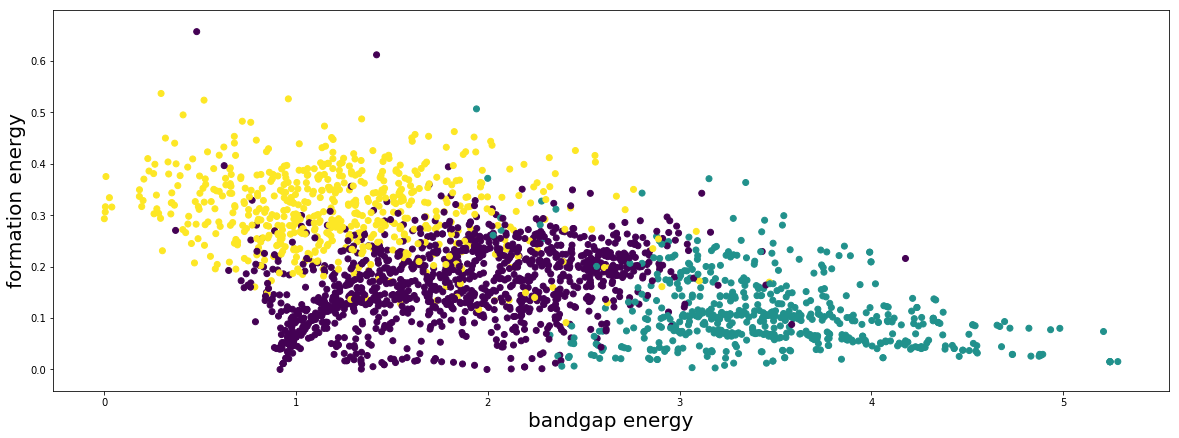

In [31]:
labels = np.array(pd.read_csv('data/add/train_labels.csv').drop('id', axis=1)).reshape((2400,))
visualize_clusters(train, labels)
plt.figure(figsize=(20, 7))
plt.scatter(train['bandgap_energy_ev'], train['formation_energy_ev_natom'], c=labels)
plt.xlabel('bandgap energy', fontsize=20)
plt.ylabel('formation energy', fontsize=20)
plt.show()

**KNN** with optimal number of neighbours was trained to classify objects on their labels (~88% 6 fold CV accuracy). Then the classifier was used to predict labels on objects from *test* dataset. The result is shown below:

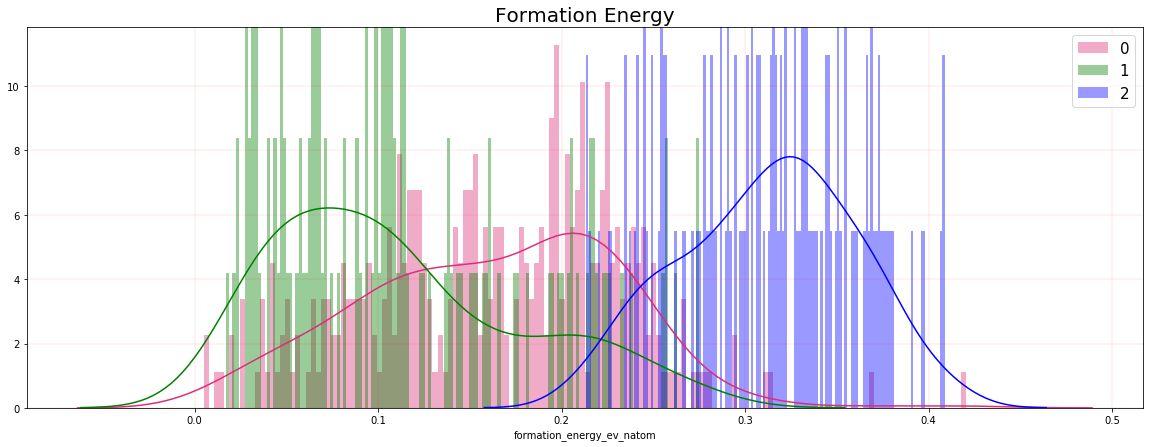

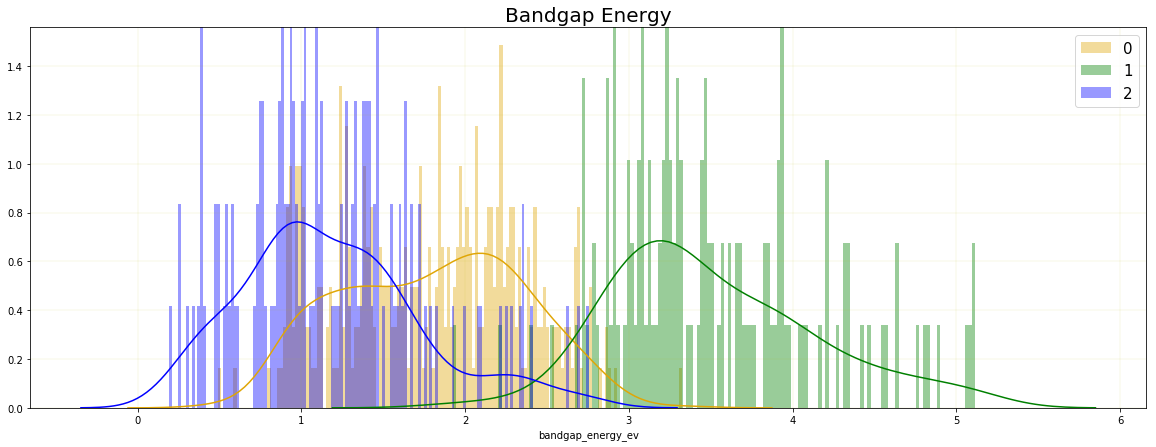

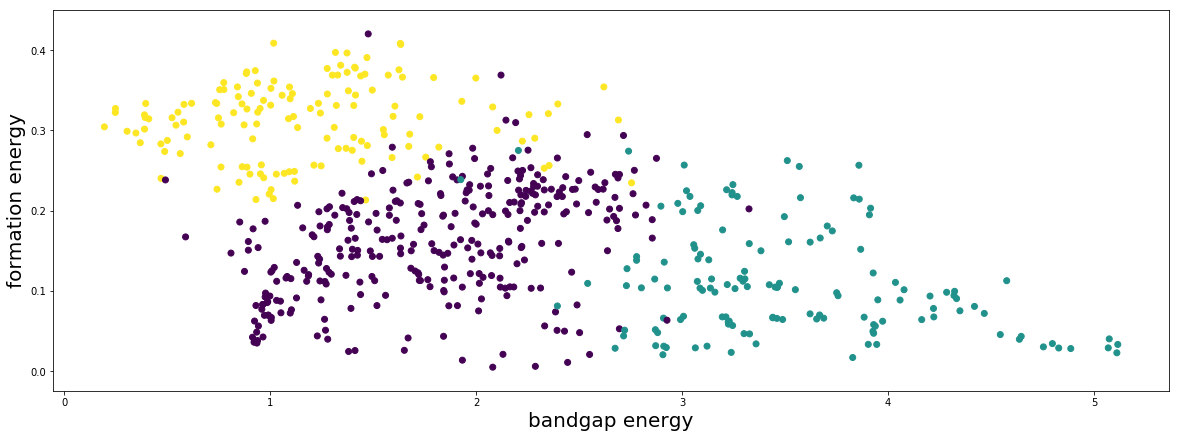

In [32]:
df = pd.read_csv('data/add/sample_submission.csv')
labels = np.array(pd.read_csv('data/add/test_labels.csv').drop('id', axis=1)).reshape((600,))
visualize_clusters(df, labels)
plt.figure(figsize=(20, 7))
plt.scatter(df['bandgap_energy_ev'], df['formation_energy_ev_natom'], c=labels)
plt.xlabel('bandgap energy', fontsize=20)
plt.ylabel('formation energy', fontsize=20)
plt.show()

As we may see the the classifier returns reasonably destributed labels. Though attempt to train separate regressors for each class was not successful due to lack of data, class labels were effectively used as a high quality feature. 

Overall after feature extraction and clustering the complete dataset contained 97 features, some of which appeared to be harmful for the model, so cleaning was needed.

## Feature selection

Custom greedy ADD-DEL algorithm was implemented to filter features and extract optimal subset of them. As turned out after a few experiments, start with an empty set of features leeds to overfitting and local minimums which are undesirable. The key decision was to start with some suboptimal set of features, which was then cleaned with ADD-DEL. 

The final training and test sets included 72 features for formation energy and 79 features for bandgap energy. These sets were the only ones used further.

## Final model
LightGBM with the following parameters was used as solo final model:

In [33]:
params_formation_enery = {
    'num_leaves'        : 32,
    'min_data_in_leaf'  : 18,
    'max_depth'         : 6,
    'learning_rate'     : 0.05,
    'feature_fraction'  : 0.7,
    'bagging_fraction'  : 0.8,
    'num_iterations'    : 600
}

params_bandgap_enerhy = {
    'num_leaves'        : 32,
    'min_data_in_leaf'  : 18,
    'max_depth'         : 6,
    'learning_rate'     : 0.05,
    'feature_fraction'  : 0.8,
    'bagging_fraction'  : 0.8,
    'num_iterations'    : 300
}

Custom Greed search was implemented for first level tuning, further tuning was performed manually.

* Best scores:
    * CV(formation energy/bandgap energy)  : 0.0107/0.0360
    * Public score                         : 0.0472 (40/895, top 5%)
    * Pricate score                        : 0.0641 (70/883, top 8%)